.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


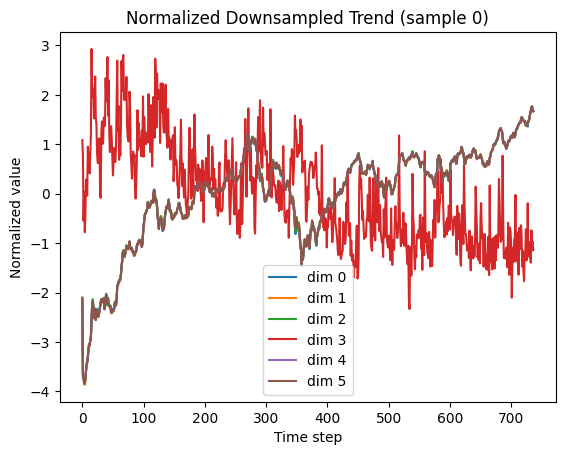

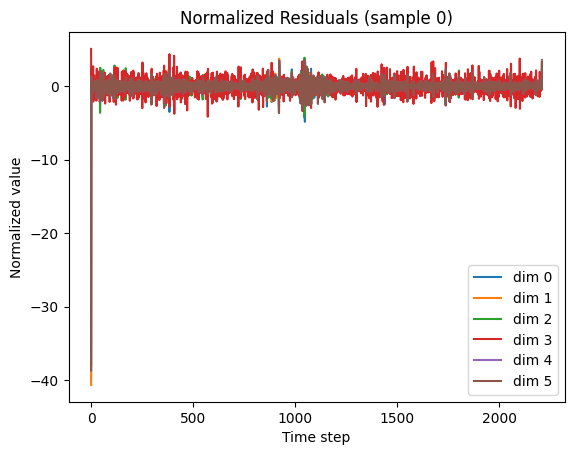

PAYAM
(1, 737, 6)
737 6 0
payam
PAYAM
PAYAM
(1, 2211, 6)
2211 6 0
payam
PAYAM
hello world, version 2
Epoch 1/1500 - Avg Loss: 1.076966
Epoch 2/1500 - Avg Loss: 0.460670
Epoch 3/1500 - Avg Loss: 0.347099
Epoch 4/1500 - Avg Loss: 0.287266
Epoch 5/1500 - Avg Loss: 0.267162
Epoch 6/1500 - Avg Loss: 0.224394
Epoch 7/1500 - Avg Loss: 0.217913
Epoch 8/1500 - Avg Loss: 0.196499
Epoch 9/1500 - Avg Loss: 0.180051
Epoch 10/1500 - Avg Loss: 0.183849
Epoch 11/1500 - Avg Loss: 0.181057
Epoch 12/1500 - Avg Loss: 0.156335
Epoch 13/1500 - Avg Loss: 0.149888
Epoch 14/1500 - Avg Loss: 0.157450
Epoch 15/1500 - Avg Loss: 0.141983
Epoch 16/1500 - Avg Loss: 0.151749
Epoch 17/1500 - Avg Loss: 0.137977
Epoch 18/1500 - Avg Loss: 0.157320
Epoch 19/1500 - Avg Loss: 0.138271
Epoch 20/1500 - Avg Loss: 0.136814
Epoch 21/1500 - Avg Loss: 0.129756
Epoch 22/1500 - Avg Loss: 0.120043
Epoch 23/1500 - Avg Loss: 0.119728
Epoch 24/1500 - Avg Loss: 0.129930
Epoch 25/1500 - Avg Loss: 0.127590
Epoch 26/1500 - Avg Loss: 0.12643

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from run_training import run_training
from helper import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_npy_path = ""

trend_model, residual_model = run_training(
    data_npy=save_npy_path,
    ma_window_size=3,       # moving average window for trend decomposition
    window_size=10,         # model window size W
    time_emb_dim=128,
    base_channels=64,
    n_res_blocks=8,
    timesteps=2000,
    s=0.007,
    batch_size=32,
    epochs=1500,
    lr=1e-3,
    device=device,
    show_detail=False,
    sample_interval=5
)

In [4]:
meta = {
    "in_channels": 6,
    "window_size": 10,
    "time_emb_dim": 128,
    "base_channels": 64,
    "n_res_blocks": 8,
    "timesteps": 2000,
    "s": 0.007,
}

save_diffpm(residual_model, trend_model, meta, "Ablation/diffpm_stock_60_1500_w10.pt")

[save_diffpm] Saved checkpoint → Ablation/diffpm_stock_60_1500_w10.pt


In [ ]:
import os, glob, math, time, json, random
from pathlib import Path
from typing import Tuple, List, Optional, Dict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# avoid dependency on sklearn by implementing our own metrics later
from collections import Counter

# ----------------- PATHS -----------------
REAL_DIR = Path("../data_fixed_60_ablation")
# real split files are expected to exist:
#   stock_data_train.npy, stock_data_val.npy, stock_data_test.npy
SYN_GLOB = "../Ablation/diffpm_stock_60_1500_*.npy"  # synthetic samples 

# ----------------- TASK (classification) ----------
TARGET_FEAT_IDX = 3     # index of the feature to predict direction on (e.g., Close)
IN_LEN   = 336          # input window length I
OUT_LEN  = 96           # forecast horizon O for the label (future move)

# ----------------- TRAINING --------------
BATCH_SIZE   = 64
EPOCHS       = 10
LR           = 2e-4
WEIGHT_DECAY = 0.05
PATIENCE     = 6
N_WORKERS    = 4

# ----------------- MODEL (Transformer classifier) --------------
D_MODEL      = 512
N_LAYERS     = 6
N_HEADS      = 8
FFN_EXPAND   = 4
DROPOUT      = 0.2
POOL         = "mean"  # "mean" or "cls"

# ----------------- AUGMENTATION (B setting) ----------
USE_SYNTHETIC      = True      # set False to run A (real-only); True for B (real+synthetic)
MAX_SYN_FILES      = None      # int or None; None = use all matching synthetic files
SYN_CLASS_WEIGHT   = 1.0       # weight of synthetic windows in training (1.0 = same as real)

# ----------------- REPRO/DEVICE ----------
SEED   = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(SEED)


Device: cuda


In [ ]:
class Standardizer:
    """Per-feature mean/std (fit on TRAIN INPUT WINDOWS ONLY)."""
    def __init__(self):
        self.mean_ = None
        self.std_  = None

    def fit(self, X_windows: np.ndarray):
        # X_windows: [num_windows, IN_LEN, D]
        mean = X_windows.reshape(-1, X_windows.shape[-1]).mean(axis=0)
        std  = X_windows.reshape(-1, X_windows.shape[-1]).std(axis=0)
        std  = np.where(std < 1e-12, 1.0, std)
        self.mean_ = mean.astype(np.float32)
        self.std_  = std.astype(np.float32)
        return self

    def transform(self, X_windows: np.ndarray):
        return (X_windows - self.mean_) / self.std_

    def fit_transform(self, X_windows: np.ndarray):
        return self.fit(X_windows).transform(X_windows)

def compute_future_log_return(series: np.ndarray, t: int, horizon: int, feat_idx: int) -> float:
    """log-return between t and t+h on a single series; safe for nonpositive by adding eps."""
    eps = 1e-8
    p0 = series[t, feat_idx]
    p1 = series[t + horizon, feat_idx]
    return float(np.log(abs(p1) + eps) - np.log(abs(p0) + eps))

def make_labels_from_returns(r: np.ndarray, q_lo: float = 0.4, q_hi: float = 0.6):
    """Map returns to {-1,0,+1} using train-derived thresholds."""
    t_lo = np.quantile(r, q_lo)
    t_hi = np.quantile(r, q_hi)
    y = np.full_like(r, 0, dtype=np.int64)
    y[r <= t_lo] = 0  # Down
    y[(r > t_lo) & (r < t_hi)] = 1  # Flat
    y[r >= t_hi] = 2  # Up
    return y, (float(t_lo), float(t_hi))

def macro_f1_from_counts(tp, fp, fn, num_classes=3):
    f1s = []
    for c in range(num_classes):
        precision = tp[c] / (tp[c] + fp[c] + 1e-9)
        recall    = tp[c] / (tp[c] + fn[c] + 1e-9)
        f1        = 2 * precision * recall / (precision + recall + 1e-9)
        f1s.append(f1)
    return float(np.mean(f1s))

def confusion_counts(y_true: np.ndarray, y_pred: np.ndarray, num_classes=3):
    tp = np.zeros(num_classes, dtype=np.float64)
    fp = np.zeros(num_classes, dtype=np.float64)
    fn = np.zeros(num_classes, dtype=np.float64)
    for c in range(num_classes):
        tp[c] = np.sum((y_pred == c) & (y_true == c))
        fp[c] = np.sum((y_pred == c) & (y_true != c))
        fn[c] = np.sum((y_pred != c) & (y_true == c))
    return tp, fp, fn

class WindowedDirectionDataset(Dataset):
    """
    Creates causal windows inside a given split (no crossing boundaries).
    X[i] = window of length IN_LEN
    y[i] = class in {0,1,2} from future OUT_LEN return, thresholds from TRAIN only.
    """
    def __init__(
        self,
        array_ntd: np.ndarray,         # shape (N, T, D) or (T, D)
        in_len: int,
        out_len: int,
        target_feat_idx: int,
        scaler: Optional[Standardizer],
        thresholds: Tuple[float, float],  # (t_lo, t_hi) from TRAIN only
        label_from: str = "logret",    # "logret"
        weight: float = 1.0,           # sample weight (e.g., for synthetic)
        split_name: str = "train"      # for sanity/debug
    ):
        super().__init__()
        if array_ntd.ndim == 2:
            array_ntd = array_ntd[None, ...]  # -> (1, T, D)
        assert array_ntd.ndim == 3
        self.X = array_ntd.astype(np.float32)  # (N, T, D)
        self.N, self.T, self.D = self.X.shape
        self.in_len = in_len
        self.out_len = out_len
        self.feat = target_feat_idx
        self.scaler = scaler
        self.t_lo, self.t_hi = thresholds
        self.weight = float(weight)
        self.split = split_name

        # Pre-index valid end times (t) for windows fully inside this split
        # Windows use [t-in_len+1 .. t] as input and target uses t+out_len
        self.indices = []  # (n, t) pairs
        for n in range(self.N):
            # feasible t range
            t_min = in_len - 1
            t_max = self.T - 1 - out_len
            if t_max >= t_min:
                for t in range(t_min, t_max + 1):
                    self.indices.append((n, t))
        self.indices = np.array(self.indices, dtype=np.int64)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        n, t = self.indices[idx]
        x_win = self.X[n, t - self.in_len + 1 : t + 1, :]  # (I, D)
        # label from future OUT_LEN step
        eps = 1e-8
        p0 = self.X[n, t, self.feat]
        p1 = self.X[n, t + self.out_len, self.feat]
        r  = float(np.log(abs(p1)+eps) - np.log(abs(p0)+eps))  # log-return

        # discretize using TRAIN thresholds
        if r <= self.t_lo:
            y = 0
        elif r >= self.t_hi:
            y = 2
        else:
            y = 1

        if self.scaler is not None:
            x_win = (x_win - self.scaler.mean_) / self.scaler.std_

        return torch.from_numpy(x_win), torch.tensor(y, dtype=torch.long), torch.tensor(self.weight, dtype=torch.float32)


In [ ]:
def load_real_splits(real_dir: Path) -> Dict[str, np.ndarray]:
    train = np.load(real_dir / "stock_data_train.npy")  # (N, Ttr, D)
    val   = np.load(real_dir / "stock_data_val.npy")    # (N, Tva, D)
    test  = np.load(real_dir / "stock_data_test.npy")   # (N, Tte, D)
    return {"train": train, "val": val, "test": test}

real = load_real_splits(REAL_DIR)
for k, v in real.items():
    print(f"{k.upper():5s} shape = {v.shape}")

# 1) derive returns & thresholds from TRAIN only (using causal windows inside train split)
def collect_train_returns(arr_train: np.ndarray, in_len: int, out_len: int, feat_idx: int) -> np.ndarray:
    if arr_train.ndim == 2:
        arr_train = arr_train[None, ...]
    N, T, D = arr_train.shape
    rets = []
    for n in range(N):
        t_min = in_len - 1
        t_max = T - 1 - out_len
        for t in range(t_min, max(t_min, t_max) + 1):
            r = compute_future_log_return(arr_train[n], t, out_len, feat_idx)
            rets.append(r)
    return np.array(rets, dtype=np.float32)

train_returns = collect_train_returns(real["train"], IN_LEN, OUT_LEN, TARGET_FEAT_IDX)
y_train_discrete, (T_LO, T_HI) = make_labels_from_returns(train_returns, q_lo=0.4, q_hi=0.6)
print(f"Train returns quantiles -> t_lo={T_LO:.6f}, t_hi={T_HI:.6f}")
print("Class balance on TRAIN (with these thresholds):",
      Counter(y_train_discrete))

# 2) fit scaler on TRAIN INPUT WINDOWS ONLY (no val/test leakage)
def sample_train_windows_for_scaler(arr_train: np.ndarray, in_len: int, out_len: int) -> np.ndarray:
    if arr_train.ndim == 2:
        arr_train = arr_train[None, ...]
    N, T, D = arr_train.shape
    Xwins = []
    for n in range(N):
        t_min = in_len - 1
        t_max = T - 1 - out_len
        for t in range(t_min, max(t_min, t_max) + 1):
            x_win = arr_train[n, t - in_len + 1 : t + 1, :]
            Xwins.append(x_win)
    if not Xwins:
        return np.empty((0, in_len, D), dtype=np.float32)
    return np.stack(Xwins, axis=0).astype(np.float32)

train_input_windows = sample_train_windows_for_scaler(real["train"], IN_LEN, OUT_LEN)
scaler = Standardizer().fit(train_input_windows)
print("Scaler fitted: mean/std shapes:", scaler.mean_.shape, scaler.std_.shape)

# 3) build real datasets
ds_train_real = WindowedDirectionDataset(real["train"], IN_LEN, OUT_LEN, TARGET_FEAT_IDX, scaler, (T_LO, T_HI), split_name="train")
ds_val_real   = WindowedDirectionDataset(real["val"],   IN_LEN, OUT_LEN, TARGET_FEAT_IDX, scaler, (T_LO, T_HI), split_name="val")
ds_test_real  = WindowedDirectionDataset(real["test"],  IN_LEN, OUT_LEN, TARGET_FEAT_IDX, scaler, (T_LO, T_HI), split_name="test")

print(f"Real windows: train={len(ds_train_real)}, val={len(ds_val_real)}, test={len(ds_test_real)}")


TRAIN shape = (1, 2211, 6)
VAL   shape = (1, 737, 6)
TEST  shape = (1, 737, 6)
Train returns quantiles -> t_lo=-0.411564, t_hi=0.120421
Class balance on TRAIN (with these thresholds): Counter({np.int64(0): 712, np.int64(2): 712, np.int64(1): 356})
Scaler fitted: mean/std shapes: (6,) (6,)
Real windows: train=1780, val=306, test=306


In [ ]:
def load_synthetic_series(glob_pattern: str, max_files: Optional[int] = None) -> np.ndarray:
    files = sorted(glob.glob(glob_pattern))
    if max_files is not None:
        files = files[:max_files]
    series = []
    for f in files:
        arr = np.load(f)  # expected shape (T, D)
        if arr.ndim != 2:
            # handle accidental shapes
            arr = np.squeeze(arr)
            if arr.ndim != 2:
                print(f"[WARN] skipping {f} with shape {arr.shape}")
                continue
        series.append(arr.astype(np.float32))
    if not series:
        return np.zeros((0, 1, real['train'].shape[-1]), dtype=np.float32)
    # pad/truncate feature dim to match real if needed (defensive)
    D_real = real['train'].shape[-1]
    fixed = []
    for s in series:
        if s.shape[-1] == D_real:
            fixed.append(s)
        elif s.shape[-1] > D_real:
            fixed.append(s[:, :D_real])
        else:
            pad = np.zeros((s.shape[0], D_real - s.shape[-1]), dtype=s.dtype)
            fixed.append(np.concatenate([s, pad], axis=1))
    # stack as (Ns, T, D) variable T is not allowed -> keep list (dataset handles per-series)
    return fixed  # list of (T, D)

synthetic_list = []
if USE_SYNTHETIC:
    synthetic_list = load_synthetic_series(SYN_GLOB, MAX_SYN_FILES)
    print(f"Synthetic series loaded: {len(synthetic_list)} files")

# build a concatenated synthetic dataset by stacking series along N dimension (pad to min T?)
# we don't need to equalize T; dataset handles each series individually via indices.
def stack_varlen_series(series_list: List[np.ndarray]) -> np.ndarray:
    if not series_list:
        return np.zeros((0, 1, real['train'].shape[-1]), dtype=np.float32)
    # stack along N (no padding, but we need a 3D array with same T -> simplest is to keep N=1 per series separately)
    # We'll just concatenate along N by placing them into a big 3D via a loop: convert to list of (1,T,D) and then np.concatenate
    blocks = [s[None, ...] for s in series_list]
    return np.concatenate(blocks, axis=0)

syn_ntd = stack_varlen_series(synthetic_list) if USE_SYNTHETIC else np.zeros((0, 1, real['train'].shape[-1]), dtype=np.float32)
print("Synthetic stacked shape:", syn_ntd.shape)

ds_train_syn = None
if USE_SYNTHETIC and syn_ntd.shape[0] > 0:
    ds_train_syn = WindowedDirectionDataset(syn_ntd, IN_LEN, OUT_LEN, TARGET_FEAT_IDX, scaler, (T_LO, T_HI),
                                            weight=SYN_CLASS_WEIGHT, split_name="train_synth")
    print("Synthetic windows (train-only):", len(ds_train_syn))


Synthetic series loaded: 10 files
Synthetic stacked shape: (10, 2211, 6)
Synthetic windows (train-only): 17800


In [ ]:
def make_loader(ds: Dataset, batch_size: int, shuffle: bool, num_workers: int):
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
                      pin_memory=True, drop_last=False)

# A: Real-only
loader_train_A = make_loader(ds_train_real, BATCH_SIZE, True, N_WORKERS)
# B: Real + Synthetic
if USE_SYNTHETIC and ds_train_syn is not None and len(ds_train_syn) > 0:
    # Concatenate via a simple wrapper
    class ConcatDataset(Dataset):
        def __init__(self, *datasets):
            self.datasets = datasets
            self.cumlens = np.cumsum([len(d) for d in datasets])
        def __len__(self): return int(self.cumlens[-1])
        def __getitem__(self, idx):
            for d, c in zip(self.datasets, self.cumlens):
                prev = 0 if c == self.cumlens[0] else self.cumlens[list(self.cumlens).index(c)-1]
                if idx < c:
                    return d[idx - prev]
            raise IndexError
    ds_train_B = ConcatDataset(ds_train_real, ds_train_syn)
    loader_train_B = make_loader(ds_train_B, BATCH_SIZE, True, N_WORKERS)
else:
    ds_train_B = ds_train_real
    loader_train_B = make_loader(ds_train_real, BATCH_SIZE, True, N_WORKERS)

loader_val  = make_loader(ds_val_real,  BATCH_SIZE, False, N_WORKERS)
loader_test = make_loader(ds_test_real, BATCH_SIZE, False, N_WORKERS)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)  # (max_len, d_model)

    def forward(self, x):  # x: (B, T, D)
        T = x.size(1)
        x = x + self.pe[:T].unsqueeze(0)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, in_dim: int, d_model: int, n_heads: int, n_layers: int, ffn_expand: int, dropout: float, pool: str = "mean"):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_model*ffn_expand,
                                                   dropout=dropout, batch_first=True, activation="gelu", norm_first=True)
        self.enc = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pos = PositionalEncoding(d_model, max_len=4096, dropout=dropout)
        self.norm = nn.LayerNorm(d_model)
        self.pool = pool
        self.cls = nn.Linear(d_model, 3)

    def forward(self, x):  # x: (B, T, D)
        h = self.proj(x)
        h = self.pos(h)
        h = self.enc(h)
        h = self.norm(h)
        if self.pool == "mean":
            h = h.mean(dim=1)
        else:
            # CLS-style: take first token
            h = h[:, 0, :]
        logits = self.cls(h)
        return logits


In [ ]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    total_w    = 0.0
    all_y, all_p = [], []

    criterion = nn.CrossEntropyLoss(reduction="none")

    for xb, yb, wb in loader:
        xb = xb.to(DEVICE).float()          # (B, I, D)
        yb = yb.to(DEVICE).long()           # (B,)
        wb = wb.to(DEVICE).float()          # (B,)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(xb)                  # (B, 3)
        loss_vec = criterion(logits, yb)    # (B,)
        # apply sample weights (synthetic may have different weight)
        loss = (loss_vec * wb).mean()

        if is_train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        total_w    += xb.size(0)

        with torch.no_grad():
            preds = torch.argmax(logits, dim=-1)
            all_y.append(yb.detach().cpu().numpy())
            all_p.append(preds.detach().cpu().numpy())

    avg_loss = total_loss / max(1, total_w)
    y = np.concatenate(all_y, axis=0) if all_y else np.zeros((0,), dtype=np.int64)
    p = np.concatenate(all_p, axis=0) if all_p else np.zeros((0,), dtype=np.int64)
    acc = float(np.mean((p == y))) if y.size > 0 else 0.0
    tp, fp, fn = confusion_counts(y, p, num_classes=3)
    f1 = macro_f1_from_counts(tp, fp, fn, num_classes=3)
    return avg_loss, acc, f1

def train_model(exp_name: str, train_loader, val_loader, max_epochs=EPOCHS, lr=LR, wd=WEIGHT_DECAY, patience=PATIENCE):
    model = TransformerClassifier(
        in_dim=real["train"].shape[-1],
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        ffn_expand=FFN_EXPAND,
        dropout=DROPOUT,
        pool=POOL,
    ).to(DEVICE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    best = {"val_f1": -1.0, "epoch": -1, "state": None}
    wait = 0

    print(f"\n=== {exp_name}: training ===")
    print(f"{'epoch':>5s} | {'tr.loss':>8s} {'tr.acc':>7s} {'tr.F1':>7s} || {'va.loss':>8s} {'va.acc':>7s} {'va.F1':>7s}")

    for epoch in range(1, max_epochs+1):
        tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc, va_f1 = run_epoch(model, val_loader,   optimizer=None)

        print(f"{epoch:5d} | {tr_loss:8.4f} {tr_acc:7.3f} {tr_f1:7.3f} || {va_loss:8.4f} {va_acc:7.3f} {va_f1:7.3f}")

        # early stopping on val F1
        if va_f1 > best["val_f1"]:
            best.update({"val_f1": va_f1, "epoch": epoch, "state": {k: v.cpu().clone() for k, v in model.state_dict().items()}})
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch} (best @ {best['epoch']})")
                break

    # load best
    model.load_state_dict(best["state"])
    return model, best

def evaluate(model, loader, name="test"):
    loss, acc, f1 = run_epoch(model, loader, optimizer=None)
    print(f"[{name}] loss={loss:.4f} acc={acc:.4f} F1={f1:.4f}")
    return {"loss": loss, "acc": acc, "f1": f1}


In [ ]:
set_seed(SEED + 0)

model_A, best_A = train_model("A: real-only", loader_train_A, loader_val, max_epochs=EPOCHS)
metrics_A_test  = evaluate(model_A, loader_test, name="A test")


.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



=== A: real-only: training ===
epoch |  tr.loss  tr.acc   tr.F1 ||  va.loss  va.acc   va.F1
    1 |   1.1655   0.404   0.370 ||   1.2073   0.425   0.199
    2 |   1.0444   0.458   0.378 ||   1.2574   0.425   0.199
    3 |   1.0198   0.492   0.384 ||   2.0869   0.252   0.134
    4 |   1.0054   0.495   0.377 ||   1.7817   0.252   0.134
    5 |   0.9763   0.521   0.455 ||   2.0400   0.252   0.134
    6 |   0.9183   0.574   0.482 ||   2.4909   0.252   0.134
    7 |   0.8724   0.601   0.509 ||   2.2989   0.252   0.134
Early stopping at epoch 7 (best @ 1)
[A test] loss=1.2806 acc=0.3431 F1=0.1703


In [ ]:
if USE_SYNTHETIC and len(ds_train_syn) > 0:
    set_seed(SEED + 1)
    model_B, best_B = train_model("B: real+synthetic", loader_train_B, loader_val, max_epochs=EPOCHS)
    metrics_B_test  = evaluate(model_B, loader_test, name="B test")
else:
    print("No synthetic data available (or USE_SYNTHETIC=False). Skipping B.")
    model_B, best_B, metrics_B_test = None, None, None


.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



=== B: real+synthetic: training ===
epoch |  tr.loss  tr.acc   tr.F1 ||  va.loss  va.acc   va.F1
    1 |   1.0862   0.421   0.302 ||   1.1357   0.304   0.241
    2 |   1.0058   0.499   0.363 ||   0.9514   0.536   0.405
    3 |   0.8583   0.615   0.485 ||   1.1143   0.428   0.371
    4 |   0.8106   0.635   0.533 ||   1.1750   0.435   0.359
    5 |   0.7813   0.652   0.557 ||   1.2962   0.428   0.384
    6 |   0.7674   0.661   0.574 ||   1.1830   0.451   0.424
    7 |   0.7536   0.664   0.583 ||   1.4711   0.399   0.332
    8 |   0.7462   0.670   0.585 ||   1.3623   0.405   0.337
    9 |   0.7404   0.672   0.589 ||   1.3962   0.438   0.392
   10 |   0.7347   0.673   0.596 ||   1.4007   0.428   0.411
[B test] loss=0.8607 acc=0.6144 F1=0.4903


In [ ]:
def fmt(m):
    return {k: (None if v is None else float(v)) for k,v in m.items()} if m else None

print("\n=== Final Comparison (Test) ===")
print("A (real-only):       ", fmt(metrics_A_test))
if metrics_B_test:
    print("B (real+synthetic):  ", fmt(metrics_B_test))
    gain_acc = metrics_B_test["acc"] - metrics_A_test["acc"]
    gain_f1  = metrics_B_test["f1"]  - metrics_A_test["f1"]
    print(f"Gain (B - A):  ΔAcc={gain_acc:+.4f}  ΔF1={gain_f1:+.4f}")
else:
    print("B: n/a")



=== Final Comparison (Test) ===
A (real-only):        {'loss': 1.2806367336534987, 'acc': 0.3431372549019608, 'f1': 0.17031630157552935}
B (real+synthetic):   {'loss': 0.8607057987474928, 'acc': 0.6143790849673203, 'f1': 0.4902795266157627}
Gain (B - A):  ΔAcc=+0.2712  ΔF1=+0.3200
